In [20]:
# Define your classes again (same as training)
CLASSES = ['no-damage','minor-damage','major-damage','destroyed']
IMG_SIZE = 320        # or 224, must match training
BACKBONE = "resnet50" # or whichever you trained with


def build_infer_pipeline(ckpt_dir: Path):
    ckpt_path = ckpt_dir / "best.pt"
    if not ckpt_path.exists():
        raise FileNotFoundError(f"No best.pt found in {ckpt_dir}, run training first")

    ckpt = torch.load(ckpt_path, map_location="cpu")
    classes  = ckpt.get("classes", ['no-damage','minor-damage','major-damage','destroyed'])
    img_size = ckpt.get("img_size", 224)
    backbone = ckpt.get("backbone", "resnet18")

    # rebuild model
    model = build_model(backbone, len(classes))
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    # base transform for inference
    base_tf = T.Compose([
        T.Resize(int(img_size*1.2)),
        T.CenterCrop(img_size),
        T.ToTensor(),
        T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    return model, base_tf, classes

Saved: viz_val_grid.png


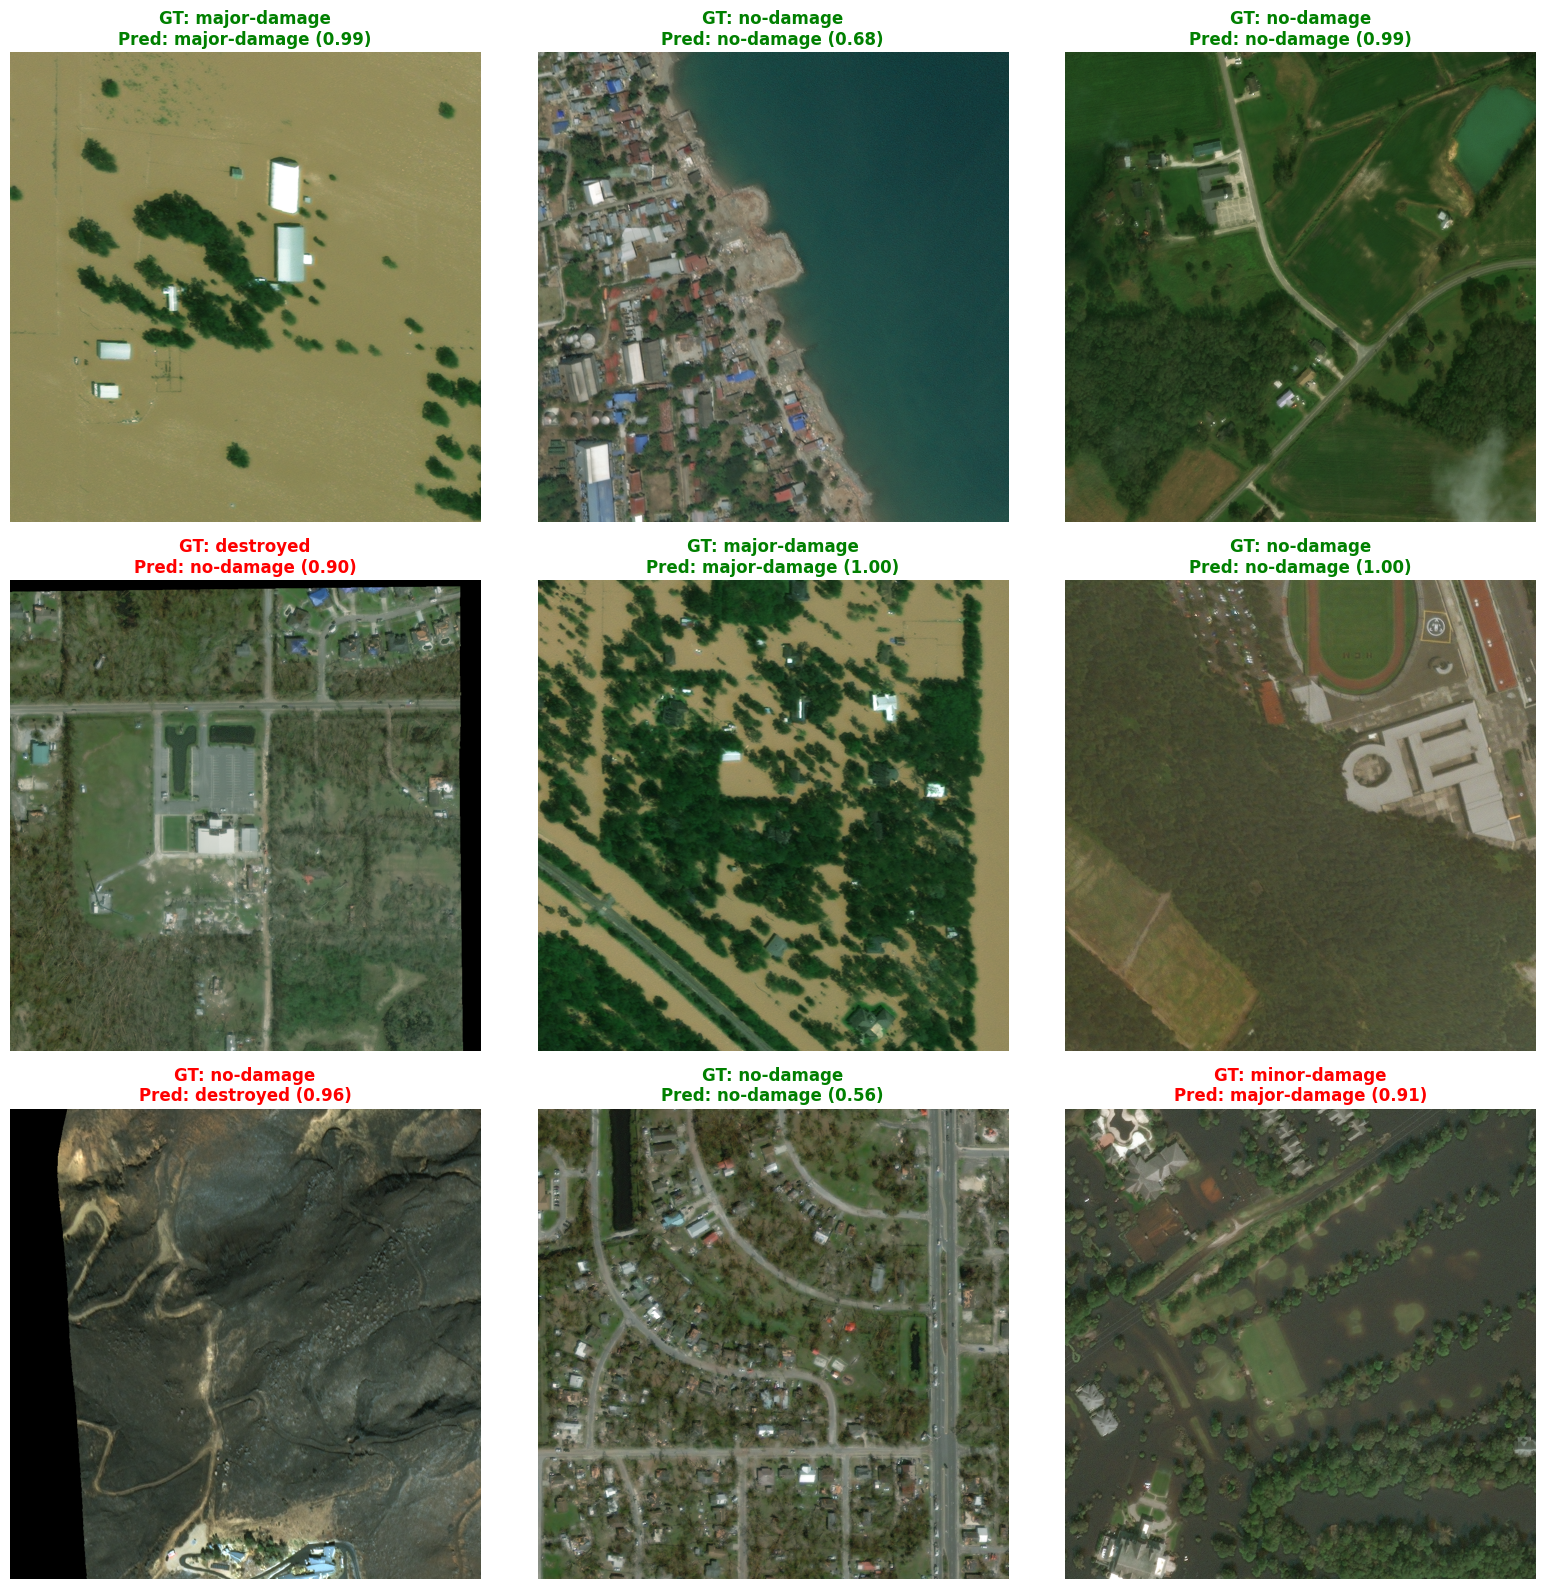

In [22]:
# ==== STEP-8 VISUALIZATION (self-contained) ===================================
import json, random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as T

# ---- paths (edit if yours differ)
CKPT_DIR = Path("checkpoints_multiclass_strong")
VAL_JL   = Path("disaster-ai/data/xbd/tier1/val.jsonl")
TTA_N    = 4          # 1 disables TTA; try 4 or 8 for smoother preds
N_SAMPLES = 9         # shown as a 3x3 grid

# ---- helpers ---------------------------------------------------------------
def resolve_img_path(p: str | Path, data_dir=Path("disaster-ai/data/xbd/tier1")) -> Path:
    p = Path(p)
    return p if p.is_absolute() else (data_dir / p)

def build_model(backbone: str, n_classes: int) -> nn.Module:
    """Rebuild the classification head for the given backbone."""
    if backbone == "resnet18":
        m = torchvision.models.resnet18(weights=None)
        m.fc = nn.Linear(m.fc.in_features, n_classes)
    elif backbone == "resnet50":
        m = torchvision.models.resnet50(weights=None)
        m.fc = nn.Linear(m.fc.in_features, n_classes)
    elif backbone == "efficientnet_b0":
        m = torchvision.models.efficientnet_b0(weights=None)
        m.classifier[1] = nn.Linear(m.classifier[1].in_features, n_classes)
    elif backbone == "vit_b_16":
        m = torchvision.models.vit_b_16(weights=None)
        m.heads.head = nn.Linear(m.heads.head.in_features, n_classes)
    else:
        raise ValueError(f"Unknown backbone: {backbone}")
    return m

def build_infer_pipeline(ckpt_dir: Path):
    """Load best.pt and return (model, base_transform, classes)."""
    ckpt_path = ckpt_dir / "best.pt"
    if not ckpt_path.exists():
        raise FileNotFoundError(f"No best.pt in {ckpt_dir}. Train first.")
    ckpt = torch.load(ckpt_path, map_location="cpu")

    classes  = ckpt.get("classes", ['no-damage','minor-damage','major-damage','destroyed'])
    img_size = ckpt.get("img_size", 224)
    backbone = ckpt.get("backbone", "resnet18")

    model = build_model(backbone, len(classes))
    model.load_state_dict(ckpt["model_state"])
    model.eval()

    base_tf = T.Compose([
        T.Resize(int(img_size*1.2)),
        T.CenterCrop(img_size),
        T.ToTensor(),
        T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    return model, base_tf, classes

def predict_one_tta(model, base_tf, classes, img_path: Path, tta_n: int = 4):
    """TTA = simple flips/rotation averaged."""
    img = Image.open(img_path).convert("RGB")
    tfs = [base_tf]
    if tta_n >= 2: tfs.append(T.Compose([T.RandomHorizontalFlip(p=1.0), *base_tf.transforms]))
    if tta_n >= 3: tfs.append(T.Compose([T.RandomVerticalFlip(p=1.0), *base_tf.transforms]))
    if tta_n >= 4: tfs.append(T.Compose([T.RandomRotation(10), *base_tf.transforms]))

    probs_sum = torch.zeros(len(classes))
    with torch.no_grad():
        for tf in tfs[:max(1, tta_n)]:
            x = tf(img).unsqueeze(0)
            logits = model(x)
            probs_sum += torch.softmax(logits, dim=1).squeeze(0)
    probs = probs_sum / len(tfs[:max(1, tta_n)])
    top = int(probs.argmax().item())
    return classes[top], float(probs[top])

# ---- load model + base transform
model, base_tf, classes = build_infer_pipeline(CKPT_DIR)

# ---- sample some validation rows
rows = [json.loads(l) for l in open(VAL_JL, "r")]
random.seed(42)
sampled = random.sample(rows, k=min(N_SAMPLES, len(rows)))

# ---- plot grid
cols = 3
rows_n = (len(sampled) + cols - 1) // cols
plt.figure(figsize=(16, 16 * rows_n / cols))

for i, r in enumerate(sampled, 1):
    pth = resolve_img_path(r["image_path"])
    pred, prob = predict_one_tta(model, base_tf, classes, pth, tta_n=TTA_N)
    gt = r["damage"]
    correct = (pred == gt)

    img = Image.open(pth).convert("RGB")
    ax = plt.subplot(rows_n, cols, i)
    ax.imshow(img); ax.axis("off")
    ax.set_title(f"GT: {gt}\nPred: {pred} ({prob:.2f})",
                 color=("green" if correct else "red"), fontsize=12, weight="bold")

plt.tight_layout()
plt.savefig("viz_val_grid.png", dpi=180)
print("Saved: viz_val_grid.png")
plt.show()
# =============================================================================